# DP task
- To validate whether the proposed model is truley transferrable by controling alpha.

Length (L1,L2), Mass (M1,M2), and Friction (F1,F2) of a string: (1,1) (1,5), (0.001,0.001)
Initial theta(degree): 0.472500(27.072256),0.344900(19.761314)
Initial omega: 0.000000,0.000000
sequence length: 600001 (3000 sec)
dt: 0.005 (sec)

subsampled sequence length: 30000 (3000 sec)
sampling dt: 0.1 (sec)


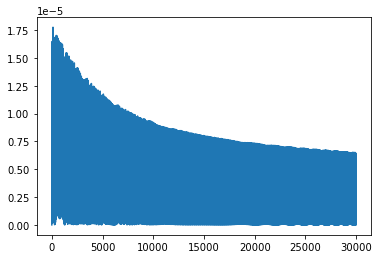

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import sys
import os

import numpy as np
from scipy.integrate import odeint
import matplotlib.pyplot as plt
from matplotlib.patches import Circle

from utils_dp import DoublePendulum
from utils_dp import calc_double_E, verification


#### Main setting
L1, L2 = 1, 1
M1, M2 = 1, 5
F1, F2 = 0.001, 0.001

#### Sub setting
# L1, L2 = 3, 1.5
# M1, M2 = 1, 3
# F1, F2 = 0.01, 0.005

# init_theta1, init_omega1 = np.random.uniform(-np.pi/4, np.pi/4), 0.0
# init_theta2, init_omega2 = np.random.uniform(-np.pi/4, np.pi/4), 0.0
init_theta1, init_omega1 = 0.4725, 0.0
init_theta2, init_omega2 = 0.3449, 0.0

#### Fast damping
# init_theta1, init_omega1 = -1.317105, 0.0
# init_theta2, init_omega2 = 1.349789, 0.0
#### Slow damping
# init_theta1, init_omega1 = 1.1365, 0.0
# init_theta2, init_omega2 = 0.2636, 0.0

dp = DoublePendulum(L1, L2, M1, M2, init_theta1, init_omega1, init_theta2, init_omega2, F1, F2)
tmax, dt = 3000, 0.005
t, y = dp.generate(tmax=tmax, dt=dt)

dp_params = {'M1': dp.M1, 'M2': dp.M2, 'L1': dp.L1, 'L2': dp.L2, 'g': dp.g, 'F1': dp.F1, 'F2': dp.F2}
# V, T, E = calc_double_E(y, **dp_params)

print('sequence length: {} ({} sec)'.format(len(y), tmax))
print('dt: {} (sec)\n'.format(dt))


subsampling = True

if subsampling:
    #### Fine dt for generation and subsample for learning
    sampling_step = 20    # sample a row for every the step.
    sampling_dt = dt*sampling_step
    sampling_ind = np.arange(0, t.shape[0]-1, sampling_step)
    sampling_t = t[sampling_ind]
    
    scaler = 1.0
    scaled_y = np.array(y)*scaler
    input_output_y = np.concatenate((scaled_y[:-1], scaled_y[1:]), axis=1)    # [[input, output]]
    X = input_output_y[sampling_ind]
    
#     scaled_y = scaled_y[sampling_ind]
#     input_output_y = np.concatenate((scaled_y[:-1], scaled_y[1:]), axis=1)    # [[input, output]]
#     X = input_output_y
    ####
else:
    sampling_dt = dt
    sampling_t = t
    
    scaler = 1.0
    scaled_y = np.array(y)*scaler
    input_output_y = np.concatenate((scaled_y[:-1], scaled_y[1:]), axis=1)    # [[input, output]]
    X = input_output_y
    

    
V, T, E = calc_double_E(X, **dp_params)
X_np = np.array(X)
    
print('subsampled sequence length: {} ({} sec)'.format(len(X), tmax))
print('sampling dt: {} (sec)'.format(sampling_dt))

_, _, cE = calc_double_E(X[:,:4], **dp_params)
_, _, nE = calc_double_E(X[:,4:], **dp_params)

plt.plot(cE-nE)

In [131]:
print(X[10])

[-0.27795078  0.08593768 -0.23287636 -1.60230799 -0.27745605  0.11154315
 -0.24092426 -1.6163811 ]


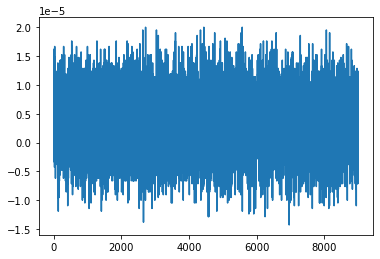

In [153]:
X_torch = torch.tensor(X_np, dtype=torch.float32)
te_x = X_torch[21000:].numpy()

_, _, cE = calc_double_E(te_x[:,:4], **dp_params)
_, _, nE = calc_double_E(te_x[:,4:], **dp_params)

plt.plot(cE-nE)

Text(0, 0.5, 'Velocity (rad/s)')

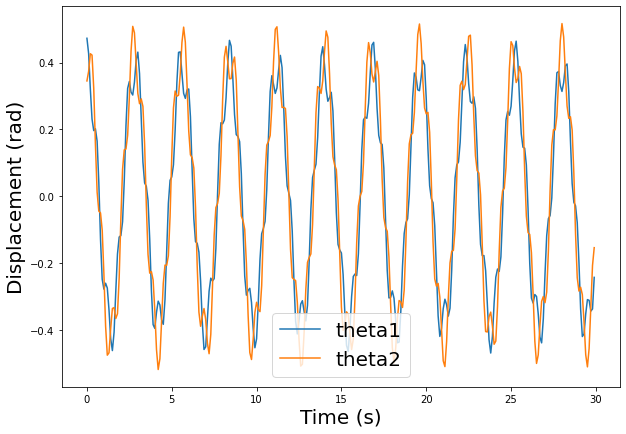

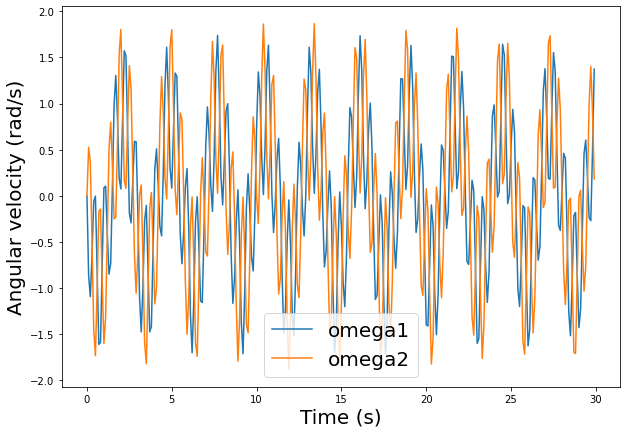

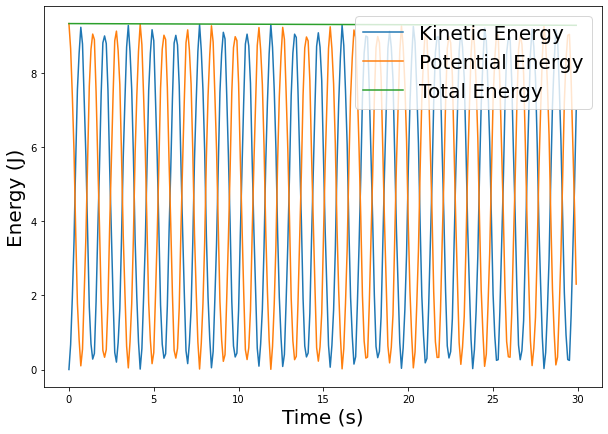

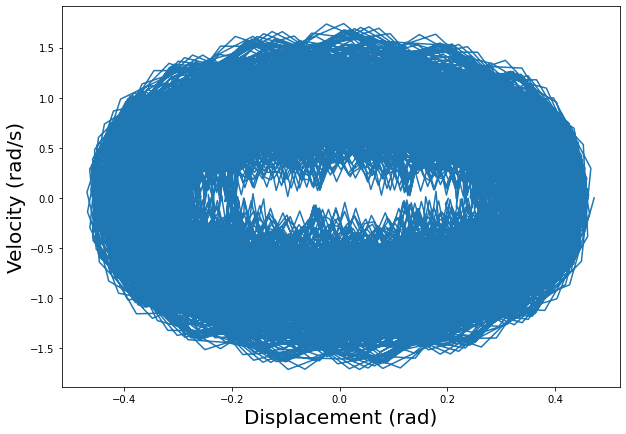

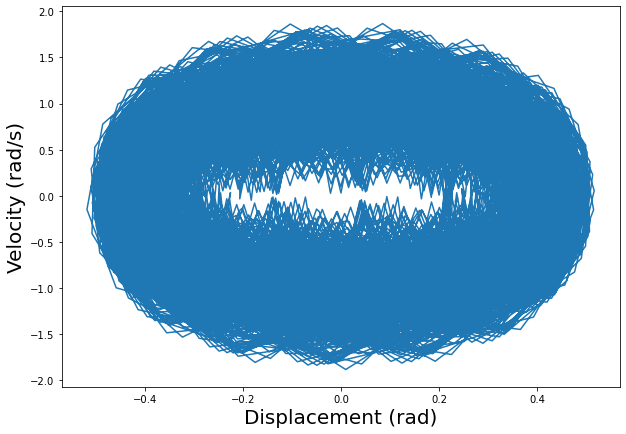

In [3]:
'''Plotting'''
# Unpack z and theta as a function of time
theta1, theta2 = X[:,0], X[:,2]
omega1, omega2 = X[:,1], X[:,3]

min_ind, max_ind = 0, len(X)//100
plt.figure(0, figsize=(10,7))
plt.plot(sampling_t[min_ind:max_ind], theta1[min_ind:max_ind], label='theta1')
plt.plot(sampling_t[min_ind:max_ind], theta2[min_ind:max_ind], label='theta2')
plt.xlabel('Time (s)', fontsize=20)
plt.ylabel('Displacement (rad)', fontsize=20)
plt.legend(loc='lower center', fontsize=20)

plt.figure(1, figsize=(10,7))
plt.plot(sampling_t[min_ind:max_ind], omega1[min_ind:max_ind], label='omega1')
plt.plot(sampling_t[min_ind:max_ind], omega2[min_ind:max_ind], label='omega2')
plt.xlabel('Time (s)', fontsize=20)
plt.ylabel('Angular velocity (rad/s)', fontsize=20)
plt.legend(loc='lower center', fontsize=20)

plt.figure(2, figsize=(10,7))
plt.plot(sampling_t[min_ind:max_ind], T[min_ind:max_ind], label='Kinetic Energy')
plt.plot(sampling_t[min_ind:max_ind], V[min_ind:max_ind], label='Potential Energy')
plt.plot(sampling_t[min_ind:max_ind], E[min_ind:max_ind], label='Total Energy')
plt.legend(loc='upper right', fontsize=20)
plt.xlabel('Time (s)', fontsize=20)
plt.ylabel('Energy (J)', fontsize=20)

plt.figure(3, figsize=(10,7))
plt.plot(theta1, omega1)
plt.xlabel('Displacement (rad)', fontsize=20)
plt.ylabel('Velocity (rad/s)', fontsize=20)

plt.figure(4, figsize=(10,7))
plt.plot(theta2, omega2)
plt.xlabel('Displacement (rad)', fontsize=20)
plt.ylabel('Velocity (rad/s)', fontsize=20)

In [17]:
!python train.py --seed 12 --shared

Namespace(F1=0.001, F2=0.001, L1=1.0, L2=1.0, M1=1.0, M2=5.0, batch_size=64, betadist_alpha=0.1, betadist_beta=0.1, constraint=0.0, delta_t=0.005, device='cuda:0', early_stopping_thld=10, epochnum=1000, extconf='', hidden_dim_db=64, hidden_dim_encoder=64, input_dim_encoder=16, lr=0.001, model_type='dataonly', n_layers=2, omega1=0.0, omega2=0.0, output_dim_encoder=64, sampling_step=20, savepath='./saved_models', scale=1.0, seed=12, shared=True, theta1=0.4725, theta2=0.3449, tmax=3000)


Generate Double-pendulum sequence...
Length (L1,L2), Mass (M1,M2), and Friction (F1,F2) of a string: (1.0,1.0) (1.0,5.0), (0.001,0.001)
Initial theta(degree): 0.472500(27.072256),0.344900(19.761314)
Initial omega: 0.000000,0.000000

sequence length: 600001 (3000 sec)
dt: 0.005 (sec)

[-0.27795078  0.08593768 -0.23287636 -1.60230799 -0.27745605  0.11154315
 -0.24092426 -1.6163811 ]
subsampled sequence length: 30000 (3000 sec)
sampling dt: 0.1 (sec)
saved_filename: ./saved_models/dp_0.4725_0.0_0.3449_0.0/d

In [13]:
!which python

/opt/conda/bin/python


## Learning a model for the prediction task
- Input: `X(t) (position, velocity)` of two objects
- Output: `X(t+1)`

In [2]:
'''
Data preprocessing for NN
'''
import random
import torch
if torch.cuda.is_available():
    device = torch.device('cuda:0')
else:
    device = torch.device('cpu')
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from torch.utils.data import DataLoader, TensorDataset



X = torch.tensor(X_np, dtype=torch.float32, device=device)

num_samples = X.shape[0]
# static_input_dim = static_X.shape[1]    # (L1,L2,M1,M2,F1,F2)
input_dim = X.shape[1]//2    # (theta1, omega1, theta2, omega2)

# 60:10:30 split
train_X, train_y = X[:int(num_samples*0.6), :input_dim], X[:int(num_samples*0.6), input_dim:]
valid_X, valid_y = X[int(num_samples*0.6):int(num_samples*0.7), :input_dim], X[int(num_samples*0.6):int(num_samples*0.7), input_dim:]
test_X, test_y = X[int(num_samples*0.7):, :input_dim], X[int(num_samples*0.7):, input_dim:]

total_train_sample = len(train_X)
total_valid_sample = len(valid_X)
total_test_sample = len(test_X)

batch_size = 64
train_loader = DataLoader(TensorDataset(train_X, train_y), batch_size=batch_size, shuffle=True)
valid_loader = DataLoader(TensorDataset(valid_X, valid_y), batch_size=valid_X.shape[0])
test_loader = DataLoader(TensorDataset(test_X, test_y), batch_size=test_X.shape[0])

print("data size: {}/{}/{}".format(len(train_X), len(valid_X), len(test_X)))

data size: 18000/3000/9000


In [140]:
print(train_X[24,:])
print(valid_X[34,:])
print(test_X[4,:])

tensor([0.3225, 0.6618, 0.1826, 0.7929], device='cuda:0')
tensor([0.1045, 0.6518, 0.1092, 0.9894], device='cuda:0')
tensor([0.3022, 0.3602, 0.3197, 0.5623], device='cuda:0')


In [268]:
from copy import deepcopy

# ret_dict_backup = deepcopy(ret_dict)

import pickle

with open('results/dp-task-results.pkl', 'wb') as file:
    pickle.dump(ret_dict, file)
ret_dict.keys()

# with open('results/m5-diff-corr-thld-0.2/m5-task-results.pkl', 'rb') as file:
#     ret_dict = pickle.load(file)
# ret_dict.keys()

dict_keys(['dataonly-nobatch', 'ours-shared-beta0.1', 'ours-shared-beta0.1-scale10', 'ours-shared-beta0.1-scale20', 'ours-shared-beta1.0', 'ours-shared-beta1.0-scale10', 'ours-shared-beta1.0-scale20'])

In [126]:
len(train_loader), 18000/64

(282, 281.25)

In [9]:
from torch.distributions.beta import Beta
from model import RuleEncoder, DataEncoder, Net, NaiveModel, SharedNet, DataonlyNet

ret_dict = dict()
model_info = {'ours-test': {'rule': 0.0, 'beta': [0.1], 'scale': 1, 'shared': True},
              'ours-shared': {'rule': 0.0, 'beta': [0.1], 'shared': True},
              'ours-shared-beta0.1': {'rule': 0.0, 'beta': [0.1], 'scale':1, 'shared': True},
              'ours-shared-beta0.1-scale2': {'rule': 0.0, 'beta': [0.1], 'scale':2, 'shared': True},
              'ours-shared-beta0.1-scale4': {'rule': 0.0, 'beta': [0.1], 'scale':4, 'shared': True},
              'ours-shared-beta0.1-scale6': {'rule': 0.0, 'beta': [0.1], 'scale':6, 'shared': True},
              'ours-shared-beta0.1-scale1.2': {'rule': 0.0, 'beta': [0.1], 'scale':1.2, 'shared': True},
              'ours-shared-beta0.1-scale1.4': {'rule': 0.0, 'beta': [0.1], 'scale':1.4, 'shared': True},
              'ours-shared-beta0.1-scale1.6': {'rule': 0.0, 'beta': [0.1], 'scale':1.6, 'shared': True},
              'ours-shared-beta0.1-scale10': {'rule': 0.0, 'beta': [0.1], 'scale':10, 'shared': True},
              'ours-shared-beta0.1-scale20': {'rule': 0.0, 'beta': [0.1], 'scale':20, 'shared': True},
              'ours-shared-beta0.1-scale50': {'rule': 0.0, 'beta': [0.1], 'scale':50, 'shared': True},
              'ours-shared-beta0.1-scale100': {'rule': 0.0, 'beta': [0.1], 'scale':100, 'shared': True},
              'ours-shared-beta0.1': {'rule': 0.0, 'beta': [1.], 'scale':1, 'shared': True},
              'ours-shared-beta1.0-scale10': {'rule': 0.0, 'beta': [1.], 'scale':10, 'shared': True},
              'ours-shared-beta1.0-scale20': {'rule': 0.0, 'beta': [1.], 'scale':20, 'shared': True},
              'ours-shared-beta1.0-scale50': {'rule': 0.0, 'beta': [1.], 'scale':50, 'shared': True},
              'ours-shared-beta1.0-scale100': {'rule': 0.0, 'beta': [1.], 'scale':100, 'shared': True},
              'dataonly': {'rule': 0.0},
              'dataonly-nobatch': {'rule': 0.0},
              'dataonly-nobatch-constraint1.0': {'rule': 0.0, 'constraint': 1.0},
              'dataonly-nobatch-constraint0.1': {'rule': 0.0, 'constraint': 0.1},
              'dataonly-nobatch-constraint0.01': {'rule': 0.0, 'constraint': 0.01},
              'ours-shared-nobatch-beta0.1': {'rule': 0.0, 'beta': [0.1], 'shared': True},
              'ours-shared-nobatch-beta0.1-scale10': {'rule': 0.0, 'beta': [0.1], 'scale': 100, 'shared': True},
              'ours-shared-nobatch-beta0.1-scale50': {'rule': 0.0, 'beta': [0.1], 'scale': 100, 'shared': True},
              'ours-shared-nobatch-beta0.1-scale100': {'rule': 0.0, 'beta': [0.1], 'scale': 100, 'shared': True},
              'ours-shared-nobatch-beta1.0': {'rule': 0.0, 'beta': [0.1], 'shared': True},
              'ours-shared-nobatch-beta1.0-scale10': {'rule': 0.0, 'beta': [1.0], 'scale': 10, 'shared': True},
              'ours-shared-nobatch-beta1.0-scale50': {'rule': 0.0, 'beta': [1.0], 'scale': 50, 'shared': True},
              'ours-shared-nobatch-beta1.0-scale100': {'rule': 0.0, 'beta': [1.0], 'scale': 100, 'shared': True},
              'ours-shared-test1': {'beta': [0.1], 'scale': 0, 'shared': True}
             }

# for model_type in ['dataonly-nobatch']:
# for model_type in ['dataonly-nobatch-constraint1.0', 'dataonly-nobatch-constraint0.1', 'dataonly-nobatch-constraint0.01']:
for model_type in ['ours-shared-test1']:

    if model_type not in model_info:
        lr = 0.001
        shared = False
        constraint = 0.0
        rule_coeff = 0.0
        pert_coeff = 0.1
        scale = 1.0
        beta_param = [1.0]
        alpha_distribution = Beta(float(beta_param[0]), float(beta_param[0]))
        model_params = {}

    else:
        model_params = model_info[model_type]
        lr = model_params['lr'] if 'lr' in model_params else 0.001
        shared = model_params['shared'] if 'shared' in model_params else False
        constraint = model_params['constraint'] if 'constraint' in model_params else 0.0
        rule_coeff = model_params['rule'] if 'rule' in model_params else 0.0
        pert_coeff = model_params['pert'] if 'pert' in model_params else 0.1
        scale = model_params['scale'] if 'scale' in model_params else 1.0
        beta_param = model_params['beta'] if 'beta' in model_params else [1.0]
        if len(beta_param) == 1:
            alpha_distribution = Beta(float(beta_param[0]), float(beta_param[0]))
        elif len(beta_param) == 2:
            alpha_distribution = Beta(float(beta_param[0]), float(beta_param[1]))

    print('model_type: {}\tscale:{}\tBeta distribution: Beta({})\tlr: {}\trule_coeff: {}\t scale: {}, constraint: {}'
          .format(model_type, scale, beta_param, lr, rule_coeff, scale, constraint))

    if model_type not in ret_dict:
        ret_dict[model_type] = {}

    for seed in range(22,23):

        random.seed(seed)
        np.random.seed(seed)
        torch.manual_seed(seed)
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = False

        lr = 0.001
        SKIP = True    # Delta value (x(t+1)-x(t)) prediction if True else absolute value (x(t+1)) prediction
        if model_type.startswith('dataonly'):
            merge = 'cat'
        elif model_type == 'dataonly-equal':
            merge = 'equal_cat'
        elif model_type.startswith('ours'):
            merge = 'cat'
        elif model_type.startswith('ruleonly'):
            merge = 'cat'

        print('model_type:{}\t merge:{}, seed {} started.'.format(model_type, merge, seed))

        input_dim = 4
        input_dim_encoder = 16
        output_dim_encoder = 64
        hidden_dim_encoder = 64
        hidden_dim_db = 64
        output_dim = 4
        n_layers = 2
        merge = 'cat'
        
        if shared:
            rule_encoder = RuleEncoder(input_dim_encoder, output_dim_encoder, hidden_dim=hidden_dim_encoder)
            data_encoder = DataEncoder(input_dim_encoder, output_dim_encoder, hidden_dim=hidden_dim_encoder)
            model = SharedNet(input_dim, output_dim, rule_encoder, data_encoder, hidden_dim=hidden_dim_db, n_layers=n_layers, merge=merge, skip=SKIP).to(device)    # delta value prediction
        else:
            rule_encoder = RuleEncoder(input_dim, output_dim_encoder, hidden_dim=hidden_dim_encoder)
            data_encoder = DataEncoder(input_dim, output_dim_encoder, hidden_dim=hidden_dim_encoder)
            if model_type.startswith('dataonly'):
                model = DataonlyNet(input_dim, output_dim, data_encoder, hidden_dim=hidden_dim_db, n_layers=n_layers, skip=SKIP).to(device)
            else:
                model = Net(input_dim, output_dim, rule_encoder, data_encoder, hidden_dim=hidden_dim_db, n_layers=n_layers, merge=merge, skip=SKIP).to(device)    # delta value prediction

        total_params = sum(p.numel() for p in model.parameters())
        print("total parameters: {}".format(total_params))

        loss_rule_func = lambda x,y: torch.mean(F.relu(x-y))    # if x>y, penalize it.
        loss_task_func = nn.L1Loss()    # return scalar (reduction=mean)
        # loss_task = nn.MSELoss()
        l1_func = nn.L1Loss()
        best_val_loss = float('inf')
        optimizer = optim.Adam(model.parameters(), lr=lr)

        epochs = 1000
        early_stopping_thld = 10
        counter_early_stopping = 1
        log_interval = 500
        valid_freq = 5
        if SKIP:
            saved_filename = 'dp-{}_{:.4f}_{:.1f}_{:.4f}_{:.1f}-seed{}.skip.demo.pt' \
                                .format(model_type, init_theta1, init_omega1, init_theta2, init_omega2, seed)
        else:
            saved_filename = 'dp-{}_{:.4f}_{:.1f}_{:.4f}_{:.1f}-no-skip.pt' \
                                .format(model_type, init_theta1, init_omega1, init_theta2, init_omega2)
        saved_filename =  os.path.join('saved_models', saved_filename)
        print('saved_filename: {}\n'.format(saved_filename))

        # Training
        for epoch in range(1, epochs+1):
            model.train()
            for batch_idx, batch_data in enumerate(train_loader):
                batch_train_x = batch_data[0] + 0.01*torch.randn(batch_data[0].shape).to(device)    # Adding noise
                batch_train_y = batch_data[1]

                optimizer.zero_grad()

                if model_type.startswith('dataonly'):
                    alpha = 0.0
                elif model_type.startswith('ruleonly'):
                    alpha = 1.0
                elif model_type.startswith('ours'):
                    alpha = alpha_distribution.sample().item()

                output = model(batch_train_x, alpha=alpha)    # only rule if alpha=1.    \hat{X}_{t+1}

                _, _, curr_E = calc_double_E(batch_train_x, **dp_params)    # E(X_t)    Energy of X_t (Current energy)
                _, _, next_E = calc_double_E(batch_train_y, **dp_params)    # E(X_{t+1})    Energy of X_{t+1} (Next energy from ground truth)
                _, _, pred_E = calc_double_E(output, **dp_params)    # E(\hat{X}_t+1)    Energy of \hat{X}_{t+1} (Next energy from prediction)

                loss_task = loss_task_func(output, batch_train_y)    # state prediction
                loss_rule = loss_rule_func(pred_E, curr_E)    # energy damping by friction: E_{t+1}<=E_t
                loss_mae = l1_func(output, batch_train_y).item()

                if constraint:
                    loss = loss_task + constraint*loss_rule    # Constrained baseline
                else:
                    if scale == 0:
                        print(loss_task, loss_rule, pred_E[5:10], curr_E[15:20])
                        scale = loss_rule.item() / loss_task.item()
                        print('scale is updated: {}'.format(scale))
                    loss = alpha * loss_rule + scale * (1-alpha) * loss_task
                loss.backward()
                optimizer.step()


            # Evaluate on validation set
            if epoch % valid_freq == 0:
                model.eval()
                with torch.no_grad():
                    val_loss_task = 0
                    val_loss_rule = 0
                    val_ratio = 0
                    for val_x, val_y in valid_loader:
                        val_x += 0.01*torch.randn(val_x.shape).to(device)
                        output = model(val_x, alpha=0.0)
                        _, _, curr_E = calc_double_E(val_x, **dp_params)
                        _, _, pred_E = calc_double_E(output, **dp_params)
                        
                        val_loss_task += (loss_task_func(output, val_y).item() * val_x.shape[0] / total_valid_sample)
                        val_loss_rule += (loss_rule_func(pred_E, curr_E) * val_x.shape[0] / total_valid_sample)
                        val_ratio += (verification(curr_E, pred_E, threshold=0.0).item() * val_x.shape[0] / total_valid_sample)

                if val_loss_task < best_val_loss:
                    counter_early_stopping = 1
                    best_val_loss = val_loss_task
                    print('[Valid] Epoch: {} Loss(Task): {:.6f} Loss(Rule): {:.6f}  Ratio(Rule): {:.3f} (alpha: 0.0)\t best model is updated %%%%'
                          .format(epoch, best_val_loss, val_loss_rule, val_ratio))
                    torch.save({
                        'epoch': epoch,
                        'model_state_dict':model.state_dict(),
                        'optimizer_state_dict': optimizer.state_dict(),
                        'loss': best_val_loss
                    }, saved_filename)
                else:
                    print('[Valid] Epoch: {} Loss(Task): {:.6f} Loss(Rule): {:.6f} Ratio(Rule): {:.3f} (alpha: 0.0) ({}/{})'
                          .format(epoch, val_loss_task, val_loss_rule, val_ratio, counter_early_stopping, early_stopping_thld))
                    if counter_early_stopping >= early_stopping_thld:
                        break
                    else:
                        counter_early_stopping += 1


        # Test
        if shared:
            rule_encoder = RuleEncoder(input_dim_encoder, output_dim_encoder, hidden_dim=hidden_dim_encoder)
            data_encoder = DataEncoder(input_dim_encoder, output_dim_encoder, hidden_dim=hidden_dim_encoder)
            model_eval = SharedNet(input_dim, output_dim, rule_encoder, data_encoder, hidden_dim=hidden_dim_db, n_layers=n_layers, merge=merge, skip=SKIP).to(device)    # delta value prediction
        else:
            rule_encoder = RuleEncoder(input_dim, output_dim_encoder, hidden_dim=hidden_dim_encoder)
            data_encoder = DataEncoder(input_dim, output_dim_encoder, hidden_dim=hidden_dim_encoder)
            if model_type.startswith('dataonly'):
                model_eval = DataonlyNet(input_dim, output_dim, data_encoder, hidden_dim=hidden_dim_db, n_layers=n_layers, skip=SKIP).to(device)
            else:
                model_eval = Net(input_dim, output_dim, rule_encoder, data_encoder, hidden_dim=hidden_dim_db, n_layers=n_layers, merge=merge, skip=SKIP).to(device)    # delta value prediction

        checkpoint = torch.load(saved_filename)
        model_eval.load_state_dict(checkpoint['model_state_dict'])
        print("best model loss: {:.6f}\t at epoch: {}".format(checkpoint['loss'], checkpoint['epoch']))

        model_eval.eval()
        with torch.no_grad():
            test_loss_task = 0
            for test_x, test_y in test_loader:
#                 test_x += 0.001*torch.randn(test_x.shape).to(device)
                output = model_eval(test_x, alpha=0.0)
                test_loss_task += (loss_task_func(output, test_y).item() * test_x.shape[0] / total_test_sample)  # sum up batch loss

        print('\nTest set: Average loss: {:.8f}\n'.format(test_loss_task))

        #### Check which parameters are updated.
        print('seed: {}'.format(seed))
        
        

        #### Best model
        test_loss_alpha = []
        test_ratio_alpha = []
        alphas = [0.0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.0]
        for alpha in alphas:
            model_eval.eval()

            with torch.no_grad():
                test_loss_task, test_ratio = 0, 0
                for test_x, test_y in test_loader:

                    if model_type.startswith('dataonly'):
                        output = model_eval(test_x, alpha=0.0)
                    elif model_type.startswith('ours'):
                        output = model_eval(test_x, alpha=alpha)
                    elif model_type.startswith('ruleonly'):
                        output = model_eval(test_x, alpha=1.0)

                    test_loss_task += (loss_task_func(output, test_y).item() * test_x.shape[0] / total_test_sample)  # sum up batch loss

                    _, _, curr_E = calc_double_E(test_x, **dp_params)
                    _, _, next_E = calc_double_E(test_y, **dp_params)
                    _, _, pred_E = calc_double_E(output, **dp_params)

                    test_ratio += (verification(curr_E, pred_E, threshold=0.0).item() * test_x.shape[0] / total_test_sample)

            print('Test set: Average loss: {:.8f} (alpha:{})'.format(test_loss_task, alpha))
            print("ratio of verified predictions: {:.6f} (alpha:{})".format(test_ratio, alpha))

            test_loss_alpha.append(test_loss_task)
            test_ratio_alpha.append(test_ratio)


        ret_dict[model_type][seed] = {'test_loss': test_loss_alpha, 'test_ratio': test_ratio_alpha}
        print()
        print()
        print()


model_type: ours-shared-test1	scale:0	Beta distribution: Beta([0.1])	lr: 0.001	rule_coeff: 0.0	 scale: 0, constraint: 0.0
model_type:ours-shared-test1	 merge:cat, seed 22 started.
total parameters: 28692
saved_filename: saved_models/dp-ours-shared-test1_0.4725_0.0_0.3449_0.0-seed22.skip.demo.pt

tensor(0.0470, device='cuda:0', grad_fn=<L1LossBackward>) tensor(0.7308, device='cuda:0', grad_fn=<MeanBackward0>) tensor([ 6.0737,  6.5457, 11.0127,  8.7662,  8.0115], device='cuda:0',
       grad_fn=<SliceBackward>) tensor([7.9198, 9.2333, 8.1993, 8.4737, 8.5604], device='cuda:0')
scale is updated: 15.553580880909422
[Valid] Epoch: 5 Loss(Task): 0.008291 Loss(Rule): 0.010004  Ratio(Rule): 0.440 (alpha: 0.0)	 best model is updated %%%%
[Valid] Epoch: 10 Loss(Task): 0.008280 Loss(Rule): 0.005471  Ratio(Rule): 0.527 (alpha: 0.0)	 best model is updated %%%%
[Valid] Epoch: 15 Loss(Task): 0.008339 Loss(Rule): 0.002915 Ratio(Rule): 0.703 (alpha: 0.0) (1/10)
[Valid] Epoch: 20 Loss(Task): 0.008410 Los

KeyboardInterrupt: 

In [129]:
tensor(0.0972, device='cuda:1') tensor([7.6032, 7.7453, 9.3345, 7.9853, 8.1764], device='cuda:1') tensor([7.5658, 8.8176, 7.8763, 8.3894, 8.5342], device='cuda:1')

{'M1': 1, 'M2': 5, 'L1': 1, 'L2': 1, 'g': 9.81, 'F1': 0.001, 'F2': 0.001}

In [10]:
checkpoint['model_state_dict']['net.0.weight'].shape

torch.Size([64, 64])

In [135]:
'''
Load saved models and evaluate them
'''
from model import RuleEncoder, DataEncoder, Net, NaiveModel, SharedNet, DataonlyNet

# model_types = ['dataonly-nobatch', 'dataonly-nobatch-constraint1.0', 'dataonly-nobatch-constraint0.1', 'dataonly-nobatch-constraint0.01',
#                'ours-shared-beta0.1', 'ours-shared-beta0.1-scale1.2', 'ours-shared-beta0.1-scale1.4',
#                'ours-shared-beta0.1-scale10', 'ours-shared-beta0.1-scale20', 'ours-shared-beta0.1-scale50', 'ours-shared-beta0.1-scale100',
#                ]
model_types = ['dataonly-nobatch', 'dataonly-nobatch-constraint1.0', 'dataonly-nobatch-constraint0.1', 'dataonly-nobatch-constraint0.01']
# ret_dict = dict()
model_types = ['ours']

for model_type in model_types:
    
    shared = True if 'shared' in model_type.split('-') else False
    shared = True

    if model_type not in ret_dict:
        ret_dict[model_type] = {}

    for seed in range(10,20):
#     for seed in range(11,12):

        random.seed(seed)
        np.random.seed(seed)
        torch.manual_seed(seed)
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = False

        SKIP = True    # Delta value (x(t+1)-x(t)) prediction if True else absolute value (x(t+1)) prediction
        if model_type.startswith('dataonly'):
            merge = 'cat'
        elif model_type == 'dataonly-equal':
            merge = 'equal_cat'
        elif model_type.startswith('ours'):
            merge = 'cat'
        elif model_type.startswith('ruleonly'):
            merge = 'cat'

        print('model_type:{}\t merge:{}, seed {} started.'.format(model_type, merge, seed))

        input_dim = 4
        input_dim_encoder = 16
        output_dim_encoder = 64
        hidden_dim_encoder = 64
        hidden_dim_db = 64
        output_dim = 4
        n_layers = 2
        merge = 'cat'


        loss_rule_func = lambda x,y: torch.mean(F.relu(x-y))    # if x>y, penalize it.
        loss_task_func = nn.L1Loss()    # return scalar (reduction=mean)
        l1_func = nn.L1Loss()

        if SKIP:
            saved_filename = 'dp-{}_{:.4f}_{:.1f}_{:.4f}_{:.1f}-seed{}.skip.demo.pt' \
                                .format(model_type, init_theta1, init_omega1, init_theta2, init_omega2, seed)
#             saved_filename = 'dp-{}_{:.4f}_{:.1f}_{:.4f}_{:.1f}-skip.pt.seed{}' \
#                                 .format(model_type, init_theta1, init_omega1, init_theta2, init_omega2, seed)
        else:
            saved_filename = 'dp-{}_{:.4f}_{:.1f}_{:.4f}_{:.1f}-no-skip.pt' \
                                .format(model_type, init_theta1, init_omega1, init_theta2, init_omega2)
        saved_filename = os.path.join('saved_models', saved_filename)
#         saved_filename = os.path.join('saved_models/dp_0.4725_0.0_0.3449_0.0-skip.pt/', saved_filename)
        print('saved_filename: {}\n'.format(saved_filename))



        # Test
        if shared:
            rule_encoder = RuleEncoder(input_dim_encoder, output_dim_encoder, hidden_dim=hidden_dim_encoder)
            data_encoder = DataEncoder(input_dim_encoder, output_dim_encoder, hidden_dim=hidden_dim_encoder)
            model_eval = SharedNet(input_dim, output_dim, rule_encoder, data_encoder, hidden_dim=hidden_dim_db, n_layers=n_layers, merge=merge, skip=SKIP).to(device)    # delta value prediction
        else:
            rule_encoder = RuleEncoder(input_dim, output_dim_encoder, hidden_dim=hidden_dim_encoder)
            data_encoder = DataEncoder(input_dim, output_dim_encoder, hidden_dim=hidden_dim_encoder)
            if model_type.startswith('dataonly'):
                model_eval = DataonlyNet(input_dim, output_dim, data_encoder, hidden_dim=hidden_dim_db, n_layers=n_layers, skip=SKIP).to(device)
            else:
                model_eval = Net(input_dim, output_dim, rule_encoder, data_encoder, hidden_dim=hidden_dim_db, n_layers=n_layers, merge=merge, skip=SKIP).to(device)    # delta value prediction

        checkpoint = torch.load(saved_filename)
        model_eval.load_state_dict(checkpoint['model_state_dict'])
        total_params = sum(p.numel() for p in model_eval.parameters())
        print("total parameters: {}".format(total_params))
        print("best model loss: {:.6f}\t at epoch: {}".format(checkpoint['loss'], checkpoint['epoch']))

        model_eval.eval()
        with torch.no_grad():
            test_loss_task = 0
            for test_x, test_y in test_loader:
                output = model_eval(test_x, alpha=0.0)
                test_loss_task += (loss_task_func(output, test_y).item() * test_x.shape[0] / total_test_sample)  # sum up batch loss

        print('\nTest set: Average loss: {:.8f}\n'.format(test_loss_task))
        noise_test_x = 0.01*torch.randn(test_x.shape).to(device)
        #### Check which parameters are updated.
        print('seed: {}'.format(seed))
        
        

        #### Best model
        test_loss_alpha = []
        test_ratio_alpha = []
        alphas = [0.0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.0]
        for alpha in alphas:
            model_eval.eval()

            with torch.no_grad():
                test_loss_task, test_ratio = 0, 0
                for test_x, test_y in test_loader:
                    
#                     test_x += noise_test_x

                    if model_type.startswith('dataonly'):
                        output = model_eval(test_x, alpha=0.0)
                    elif model_type.startswith('ours'):
                        output = model_eval(test_x, alpha=alpha)
                    elif model_type.startswith('ruleonly'):
                        output = model_eval(test_x, alpha=1.0)

                    test_loss_task += (loss_task_func(output, test_y).item() * test_x.shape[0] / total_test_sample)  # sum up batch loss

                    _, _, curr_E = calc_double_E(test_x, **dp_params)
                    _, _, next_E = calc_double_E(test_y, **dp_params)
                    _, _, pred_E = calc_double_E(output, **dp_params)

                    test_ratio += (verification(curr_E, pred_E, threshold=0.0).item() * test_x.shape[0] / total_test_sample)

            print('Test set: Average loss: {:.8f} (alpha:{})'.format(test_loss_task, alpha))
            print("ratio of verified predictions: {:.6f} (alpha:{})".format(test_ratio, alpha))

            test_loss_alpha.append(test_loss_task)
            test_ratio_alpha.append(test_ratio)


        ret_dict[model_type][seed] = {'test_loss': test_loss_alpha, 'test_ratio': test_ratio_alpha}
        print()
        print()
        print()

model_type:ours	 merge:cat, seed 11 started.
saved_filename: saved_models/dp_0.4725_0.0_0.3449_0.0-skip.pt/dp-ours_0.4725_0.0_0.3449_0.0-skip.pt.seed11

total parameters: 28692
best model loss: 0.007467	 at epoch: 115

Test set: Average loss: 0.00470456

seed: 11
Test set: Average loss: 0.00470456 (alpha:0.0)
ratio of verified predictions: 0.005000 (alpha:0.0)
Test set: Average loss: 0.00471741 (alpha:0.1)
ratio of verified predictions: 0.003889 (alpha:0.1)
Test set: Average loss: 0.00473872 (alpha:0.2)
ratio of verified predictions: 0.002556 (alpha:0.2)
Test set: Average loss: 0.00476753 (alpha:0.3)
ratio of verified predictions: 0.001889 (alpha:0.3)
Test set: Average loss: 0.00480294 (alpha:0.4)
ratio of verified predictions: 0.001556 (alpha:0.4)
Test set: Average loss: 0.00484455 (alpha:0.5)
ratio of verified predictions: 0.001000 (alpha:0.5)
Test set: Average loss: 0.00489093 (alpha:0.6)
ratio of verified predictions: 0.000889 (alpha:0.6)
Test set: Average loss: 0.00494398 (alpha:0

In [91]:
ret_dict['TaskOnly'] = ret_dict['dataonly-nobatch']
ret_dict['TaskOnly-const1.0'] = ret_dict['dataonly-nobatch-constraint1.0']
ret_dict['TaskOnly-const0.1'] = ret_dict['dataonly-nobatch-constraint0.1']
ret_dict['TaskOnly-const0.01'] = ret_dict['dataonly-nobatch-constraint0.01']

ret_dict['Ours'] = ret_dict['ours-shared-beta0.1']
ret_dict['Ours-Scale'] = ret_dict['ours-shared-beta0.1-scale10']

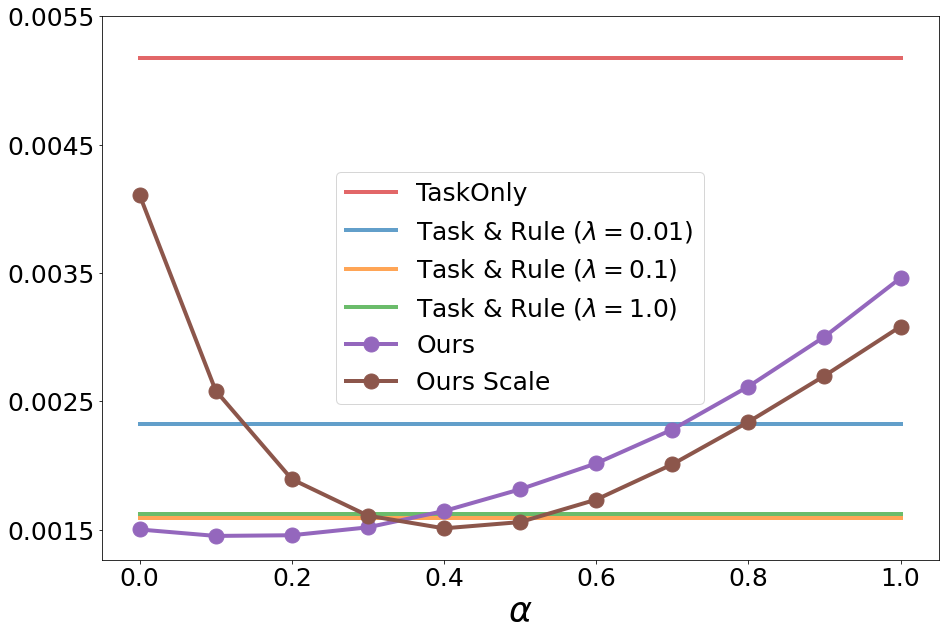

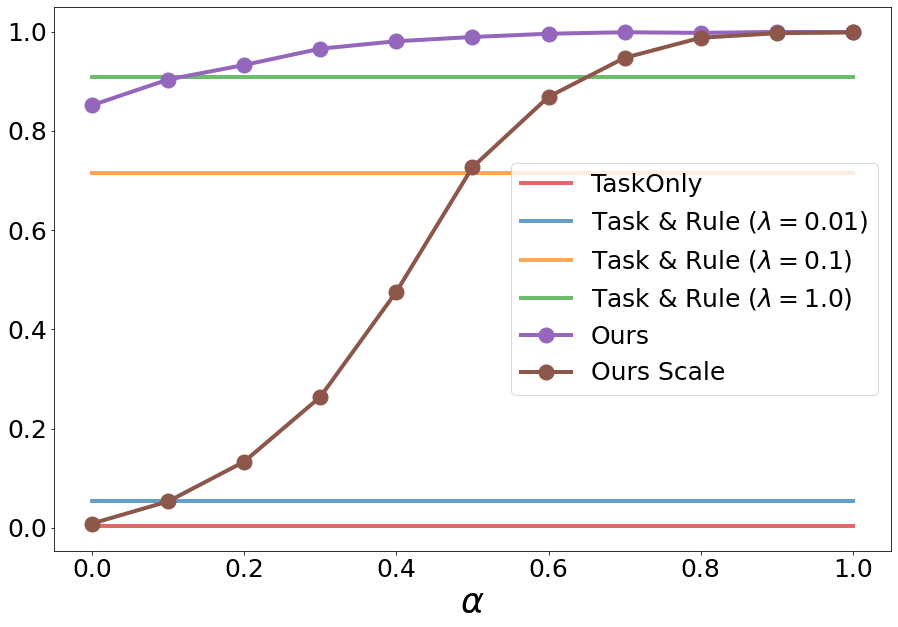

In [122]:
'''
Visualization
'''
colors = ['tab:red', 'tab:blue', 'tab:orange', 'tab:green', 'tab:purple', 'tab:brown', 'tab:pink', 'tab:gray', 'tab:olive', 'tab:cyan']*20

for key, val in ret_dict.items():
    test_loss_list = []
    test_ratio_list = []
    for seed, subval in val.items():
        if isinstance(seed, int):
            test_loss_list.append(subval['test_loss'])
            test_ratio_list.append(subval['test_ratio'])
            
    val['test_loss_avg'] = np.mean(np.array(test_loss_list), 0)
    val['test_loss_std'] = np.std(np.array(test_loss_list), 0)
    val['test_ratio_avg'] = np.mean(np.array(test_ratio_list), 0)
    val['test_ratio_std'] = np.std(np.array(test_ratio_list), 0)

key_list = ret_dict.keys()
key_list = ['TaskOnly', 'TaskOnly-const0.01', 'TaskOnly-const0.1', 'TaskOnly-const1.0', 'Ours', 'Ours-Scale']
    
i, ii = 0, 15
fig, ax = plt.subplots(figsize=(15,10))
# for j, (key, val) in enumerate(ret_dict.items()):
for key in key_list:
    val = ret_dict[key]
    ltype = '-' if key.startswith('dataonly') or key.startswith('TaskOnly') else 'o-'
#     plt.plot(alphas[:ii], val['test_loss_avg'][:ii], ltype, color=colors[i], lw=4, ms=15, label='MAE ({})'.format(key))
#     plt.fill_between(alphas[:ii], val['test_loss_avg'][:ii] - val['test_loss_std'][:ii], val['test_loss_avg'][:ii] + val['test_loss_std'][:ii], color=colors[i], alpha=0.3)
    if key == 'TaskOnly':
        ax.plot(alphas[:ii], val['test_loss_avg'][:ii], ls='solid', color=colors[i], alpha=0.7, lw=4, ms=15, label='TaskOnly')
    elif key.startswith('TaskOnly-'):
        weight = key.split('-')[1][5:]
        ax.plot(alphas[:ii], val['test_loss_avg'][:ii], ltype, color=colors[i], lw=4, alpha=0.7, ms=15, label='Task & Rule '+r'$(\lambda={})$'.format(weight))
    elif key == 'Ours-Scale':
        ax.plot(alphas[:ii], val['test_loss_avg'][:ii], ltype, color=colors[i], lw=4, ms=15, label='Ours Scale')
    elif key == 'Ours':
        ax.plot(alphas[:ii], val['test_loss_avg'][:ii], ltype, color=colors[i], lw=4, ms=15, label='{}'.format(key))
        
    i += 1
    
ax.yaxis.set_ticks(np.arange(0.0015, 0.0056, 0.001))
plt.xlabel(r'$\alpha$', fontsize=35)
plt.xticks(fontsize=25)
# plt.xticks([])
plt.yticks(fontsize=25)
# plt.legend(fontsize=20, bbox_to_anchor=(1.01, 1), loc='upper left')
plt.legend(fontsize=25)
# plt.ylim(0.0005, 0.003)
plt.savefig('img/dp-mae.pdf', bbox_inches='tight')


fig, ax = plt.subplots(figsize=(15,10))
i = 0
# for j, (key, val) in enumerate(ret_dict.items()):
for key in key_list:
    val = ret_dict[key]
    ltype = '-' if key.startswith('dataonly') or key.startswith('TaskOnly') else 'o-'
#     plt.plot(alphas, val['test_ratio_avg'], ltype, color=colors[i], lw=4, ms=15, label='Verification Ratio ({})'.format(key))
#     plt.fill_between(alphas, val['test_ratio_avg'] - val['test_ratio_std'], val['test_ratio_avg'] + val['test_ratio_std'], color=colors[i], alpha=0.3)
    if key == 'TaskOnly':
        ax.plot(alphas[:ii], val['test_ratio_avg'][:ii], ls=ltype, color=colors[i], alpha=0.7, lw=4, ms=15, label='TaskOnly')
    elif key.startswith('TaskOnly-'):
        weight = key.split('-')[1][5:]
        ax.plot(alphas[:ii], val['test_ratio_avg'][:ii], ltype, color=colors[i], lw=4, alpha=0.7, ms=15, label='Task & Rule '+r'$(\lambda={})$'.format(weight))
    elif key == 'Ours-Scale':
        ax.plot(alphas[:ii], val['test_ratio_avg'][:ii], ltype, color=colors[i], lw=4, ms=15, label='Ours Scale')
    elif key == 'Ours':
        ax.plot(alphas[:ii], val['test_ratio_avg'][:ii], ltype, color=colors[i], lw=4, ms=15, label='{}'.format(key))
    i += 1

plt.xlabel(r'$\alpha$', fontsize=35)
plt.xticks(fontsize=25)
# plt.xticks([])
plt.yticks(fontsize=25)
# plt.legend(fontsize=20, bbox_to_anchor=(1.01, 1), loc='upper left')
plt.legend(fontsize=25)
plt.savefig('img/dp-verification-ratio.pdf', bbox_inches='tight')

saved_models/dp-dataonly-nobatch_0.4725_0.0_0.3449_0.0-seed10.skip.demo.pt
best model loss: 0.007130	 at epoch: 80
Test set: Average loss: 0.00555958 (alpha:0.0)
ratio of verified predictions: 0.000222 (alpha:0.0)
saved_models/dp-dataonly-nobatch-constraint1.0_0.4725_0.0_0.3449_0.0-seed10.skip.demo.pt
best model loss: 0.007601	 at epoch: 190
Test set: Average loss: 0.00218415 (alpha:0.0)
ratio of verified predictions: 0.838222 (alpha:0.0)
saved_models/dp-ours-shared-beta0.1_0.4725_0.0_0.3449_0.0-seed10.skip.demo.pt
best model loss: 0.008212	 at epoch: 35
Test set: Average loss: 0.00142118 (alpha:0.2)
ratio of verified predictions: 0.999889 (alpha:0.2)


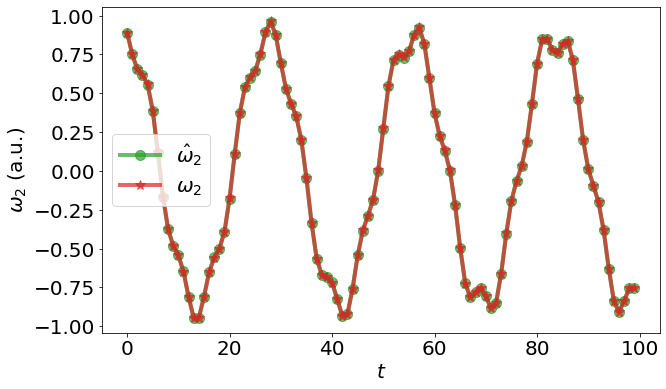

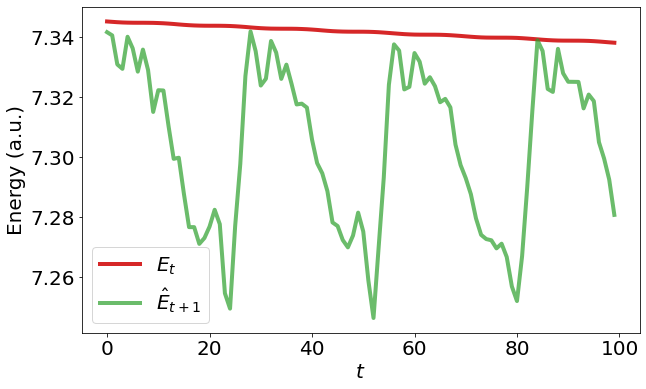

In [79]:
import matplotlib as mpl

# mpl.style.use('default')

curr_E_dict = {}
pred_E_dict = {}
seed = 10

for model_type, shared, alpha in [('dataonly-nobatch', False, 0.0),
                                  ('dataonly-nobatch-constraint1.0', False, 0.0),
                                  ('ours-shared-beta0.1', True, 0.2)]:
# model_type, shared, alpha = 'dataonly-nobatch', False, 0.0
# model_type, shared, alpha = 'dataonly-nobatch-constraint1.0', False, 0.0
# model_type, shared, alpha = 'ours-shared-beta0.1-scale1.2', True, 0.1

    if shared:
        rule_encoder = RuleEncoder(input_dim_encoder, output_dim_encoder, hidden_dim=hidden_dim_encoder)
        data_encoder = DataEncoder(input_dim_encoder, output_dim_encoder, hidden_dim=hidden_dim_encoder)
        model_eval = SharedNet(input_dim, output_dim, rule_encoder, data_encoder, hidden_dim=hidden_dim_db, n_layers=n_layers, merge=merge, skip=SKIP).to(device)    # delta value prediction
    else:
        rule_encoder = RuleEncoder(input_dim, output_dim_encoder, hidden_dim=hidden_dim_encoder)
        data_encoder = DataEncoder(input_dim, output_dim_encoder, hidden_dim=hidden_dim_encoder)
        if model_type.startswith('dataonly'):
            model_eval = DataonlyNet(input_dim, output_dim, data_encoder, hidden_dim=hidden_dim_db, n_layers=n_layers, skip=SKIP).to(device)
        else:
            model_eval = Net(input_dim, output_dim, rule_encoder, data_encoder, hidden_dim=hidden_dim_db, n_layers=n_layers, merge=merge, skip=SKIP).to(device)    # delta value prediction

    saved_filename = 'saved_models/dp-{}_0.4725_0.0_0.3449_0.0-seed{}.skip.demo.pt'.format(model_type, seed)
    print(saved_filename)
    checkpoint = torch.load(saved_filename)
    model_eval.load_state_dict(checkpoint['model_state_dict'])
    print("best model loss: {:.6f}\t at epoch: {}".format(checkpoint['loss'], checkpoint['epoch']))


    with torch.no_grad():
        test_loss_task, test_ratio = 0, 0
        for test_x, test_y in test_loader:
            break

        if model_type.startswith('dataonly'):
            output = model_eval(test_x, alpha=0.0)
        elif model_type.startswith('ours'):
            output = model_eval(test_x, alpha=alpha)
        elif model_type.startswith('ruleonly'):
            output = model_eval(test_x, alpha=1.0)

        test_loss_task = loss_task_func(output, test_y).item()  # sum up batch loss

        _, _, curr_E = calc_double_E(test_x, **dp_params)
        _, _, next_E = calc_double_E(test_y, **dp_params)
        _, _, pred_E = calc_double_E(output, **dp_params)

        test_ratio = verification(curr_E, pred_E, threshold=0.0).item()
        print('Test set: Average loss: {:.8f} (alpha:{})'.format(test_loss_task, alpha))
        print("ratio of verified predictions: {:.6f} (alpha:{})".format(test_ratio, alpha))

    curr_E_dict[model_type] = curr_E.cpu().numpy()
    pred_E_dict[model_type] = pred_E.cpu().numpy()
    
'''
Visualization of predicted/ground truth observation
    - To show the prediction is very accurate from dataonly.
'''
fig, ax = plt.subplots(figsize=(10,6))

ind = 100
input_ind = 3    # 0: theta1, 1: omega1, 2: theta2, 3: omega2
ylabel = {0: r'$\theta_1$', 1: r'$\omega_1$', 2: r'$\theta_2$', 3: r'$\omega_2$'}
ylabel_pred = {0: r'$\hat{\theta}_1$', 1: r'$\hat{\omega}_1$', 2: r'$\hat{\theta}_2$', 3: r'$\hat{\omega}_2$'}
input_x = test_x.cpu().numpy()
pred = output.cpu().numpy()
target = test_y.cpu().numpy()
ax.plot(pred[:ind, input_ind], 'o-', color='tab:green', lw=4, ms=10, alpha=0.7, label=ylabel_pred[input_ind])
ax.plot(target[:ind, input_ind], '-*', color='tab:red', lw=4, ms=10, alpha=0.7, label=ylabel[input_ind])

plt.xlabel(r'$t$', fontsize=20)
plt.ylabel(ylabel[input_ind] + ' (a.u.)', fontsize=20)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
# plt.yticks([])
plt.legend(fontsize=20)


'''
Visualization of predicted/ground truth Energy
    - Energy prediction violates the common rule.
'''

fig, ax = plt.subplots(figsize=(10,6))

# ind = 100
ax.plot(curr_E.cpu().numpy()[:ind], '-', color='tab:red', lw=4, ms=10, alpha=1.0, label=r'$E_t$')
ax.plot(pred_E.cpu().numpy()[:ind], '-', color='tab:green', lw=4, ms=10, alpha=0.7, label=r'$\hat{E}_{t+1}$')
# ax.plot(next_E.cpu().numpy()[:ind], '-', color='tab:blue', lw=4, ms=10, alpha=1.0, label=r'$E_{t+1}$')

plt.xlabel(r'$t$', fontsize=20)
plt.ylabel('Energy (a.u.)', fontsize=20)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
# plt.yticks([])
plt.legend(fontsize=20)

# plt.savefig('img/dp-data-only.pdf', bbox_inches='tight')
# plt.savefig('img/dp-hybrid.pdf', bbox_inches='tight')

In [68]:
curr_E_dict.keys()

dict_keys(['dataonly-nobatch', 'dataonly-nobatch-constraint1.0', 'ours-shared-beta0.1'])

In [71]:
np.allclose(curr_E_dict['dataonly-nobatch'], curr_E_dict['ours-shared-beta0.1'])

True

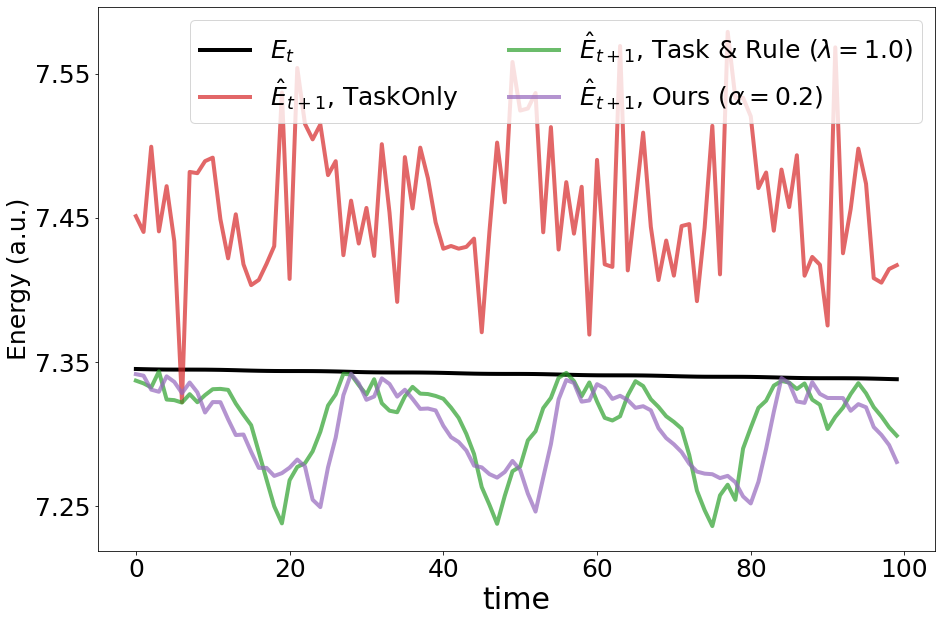

In [120]:
fig, ax = plt.subplots(figsize=(15,10))

# ind = 100
ax.plot(curr_E_dict['dataonly-nobatch'][:ind], '-', color='black', lw=4, ms=10, alpha=1.0, label=r'$E_t$')
ax.plot(pred_E_dict['dataonly-nobatch'][:ind], '-', color='tab:red', lw=4, ms=10, alpha=0.7, label=r'$\hat{E}_{t+1}$' + ', TaskOnly')
ax.plot(pred_E_dict['dataonly-nobatch-constraint1.0'][:ind], '-', color='tab:green', lw=4, ms=10, alpha=0.7, label=r'$\hat{E}_{t+1}$' + ', Task & Rule ' + r'($\lambda=1.0$)')
ax.plot(pred_E_dict['ours-shared-beta0.1'][:ind], '-', color='tab:purple', lw=4, ms=10, alpha=0.7, label=r'$\hat{E}_{t+1}$' + ', Ours ' + r'$(\alpha=0.2)$')

ax.yaxis.set_ticks(np.arange(7.25, 7.56, 0.1))
plt.xlabel('time', fontsize=30)
plt.ylabel('Energy (a.u.)', fontsize=25)
plt.xticks(fontsize=25)
plt.yticks(fontsize=25)
# plt.yticks([])
plt.legend(fontsize=25, ncol=2)
plt.savefig('img/dp-energy.pdf', bbox_inches='tight')